<a href="https://colab.research.google.com/github/MoAbbasid/100_Days_of_Code/blob/main/Vision%20Transformer%20(ViT)/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import einops
import tqdm
from torchsummary import summary
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
# from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split


In [59]:
patchsize = 4
latent_size = 384
n_channels = 3
heads = 12
n_encoders = 12
dropout = 0.1
n_classes = 100
img_size = (32, 32)

epochs = 40
base_lr = 10e-4
weight_decay = 0.03
batch_size = 64

In [21]:
x = torch.randn(2, 3, 480, 480)  # (batch_size=2, 3 channels, 224x224)

In [54]:
# if each x is (b,c, (h * h1), (w *w1)), change it to (b, (h*w), (h1 *w1 *c))
patches = einops.rearrange(
    x, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)',
    h1=patchsize, w1=patchsize
)

In [55]:
patches.shape

torch.Size([10, 49, 16])

In [24]:
# linear transformation, i
input_size = patchsize * patchsize * n_channels
linear = nn.Linear(input_size, latent_size)
x_linear = linear(patches)
print("Before Linear Projection:", patches.shape)  # (batch_size, num_patches, 768)
print("After Linear Projection:", x_linear.shape) # (batch_size, num_patches, latent_size)

Before Linear Projection: torch.Size([2, 900, 768])
After Linear Projection: torch.Size([2, 900, 768])


In [25]:
# define class token and CONCAT it (not add) to the input
cls_token = nn.Parameter(torch.randn(x_linear.shape[0], 1, latent_size))
x_prepend = torch.cat([cls_token, x_linear], dim=1)

print(x_prepend.shape)

torch.Size([2, 901, 768])


In [26]:
# prepare Positional embedding and ADD it (not CONCAT), reason is in rant in README
print(x_prepend[0])
pos_emb = nn.Parameter(torch.randn(x_prepend.shape[0], 1, latent_size))
pos_embed = einops.repeat(pos_emb, 'b 1 d -> b m d', m=x_prepend.shape[1])
x_prepend += pos_embed

print(x_prepend.shape)
print(x_prepend[0])

tensor([[ 0.9711, -1.6223,  2.0947,  ...,  0.0547,  0.7990,  0.4242],
        [-0.1685,  0.4642, -0.2568,  ..., -1.1836, -0.2462,  0.4306],
        [-0.4059, -0.6787, -0.0709,  ...,  0.6492, -0.3008, -0.4211],
        ...,
        [ 0.3604,  0.0279, -0.6608,  ..., -0.8624, -0.7567,  0.7513],
        [-0.9115, -0.3779,  0.0934,  ...,  0.6362,  0.2625, -1.0339],
        [-0.0198,  0.1328, -0.3328,  ..., -0.1218,  0.5766, -0.8215]],
       grad_fn=<SelectBackward0>)
torch.Size([2, 901, 768])
tensor([[ 1.0876, -1.3653,  1.8329,  ...,  1.1732,  1.5712,  0.3266],
        [-0.0521,  0.7212, -0.5186,  ..., -0.0651,  0.5260,  0.3330],
        [-0.2895, -0.4217, -0.3327,  ...,  1.7677,  0.4714, -0.5187],
        ...,
        [ 0.4768,  0.2850, -0.9226,  ...,  0.2561,  0.0155,  0.6537],
        [-0.7950, -0.1209, -0.1684,  ...,  1.7547,  1.0347, -1.1315],
        [ 0.0966,  0.3898, -0.5946,  ...,  0.9967,  1.3488, -0.9191]],
       grad_fn=<SelectBackward0>)


In [33]:
# b, n, d = x.shape  # batch_size, num_patches, latent_size (embedding_dim)
heads = 12
head_dim = latent_size // heads  # Each head gets a fraction of d
W_q = nn.Linear(latent_size, latent_size)
W_k = nn.Linear(latent_size, latent_size)
W_v = nn.Linear(latent_size, latent_size)

Q = W_q(x_prepend)  # (batch_size, num_patches, latent_size)
K = W_k(x_prepend)  # (batch_size, num_patches, latent_size)
V = W_v(x_prepend)  # (batch_size, num_patches, latent_size)
Q = Q.view(x_prepend.shape[0], x_prepend.shape[1], heads, head_dim).transpose(1, 2)  # (x_prepend.shape[0]_, heads, n, head_dim)
K = K.view(x_prepend.shape[0], x_prepend.shape[1], heads, head_dim).transpose(1, 2)
V = V.view(x_prepend.shape[0], x_prepend.shape[1], heads, head_dim).transpose(1, 2)
# Q (batch, heads, num_patches(tokens), heads_dim) @ K (batch, head, heads_dim, num_pathces(tokens))
attn_scores = (Q @ K.transpose(-2, -1)) / (head_dim ** 0.5)  # (batch_size, heads, num_patches, num_patches)
attn_weights = attn_scores.softmax(dim=-1)  # Normalize
out = attn_weights @ V  # (batch, heads, num_patches, head_dim)

In [34]:
# print shapes to verify
print(Q.shape)
print(K.shape)
print(V.shape)
print(attn_scores.shape)
# print(attn_weights.shape)
print(out.shape)

torch.Size([2, 12, 901, 64])
torch.Size([2, 12, 901, 64])
torch.Size([2, 12, 901, 64])
torch.Size([2, 12, 901, 901])
torch.Size([2, 12, 901, 64])


In [35]:
out = out.transpose(1, 2).contiguous().view(x_prepend.shape[0], x_prepend.shape[1], latent_size)  # (batch, num patches, latent)
W_out = nn.Linear(latent_size, latent_size)
out = W_out(out)  # Final projection
print(out.shape)

torch.Size([2, 901, 768])


In [36]:
# Encoder Block
x = x_prepend + out  # (batch_size, num_tokens, latent_size)
x = nn.LayerNorm(latent_size)(x)  # (batch_size, num_tokens, latent_size)
ffn = nn.Sequential(
    nn.Linear(latent_size, latent_size * 4),  # Expand
    nn.GELU(),  # Activation
    nn.Linear(latent_size * 4, latent_size)  # Compress back
)

x_ffn = ffn(x)  # (batch_size, num_tokens, latent_size)
print(x_ffn.shape)
print(x_ffn[0])

torch.Size([2, 901, 768])
tensor([[ 0.2769,  0.0465,  0.0276,  ..., -0.0398, -0.0517,  0.2432],
        [ 0.0640, -0.0236, -0.0203,  ..., -0.0121,  0.0790,  0.2662],
        [ 0.0106, -0.1444, -0.0957,  ..., -0.0334,  0.0576,  0.0254],
        ...,
        [ 0.1129, -0.1557,  0.0547,  ...,  0.1222,  0.1756,  0.2690],
        [-0.0259, -0.1673, -0.1239,  ..., -0.0359, -0.1753,  0.2923],
        [ 0.0213, -0.1180,  0.1396,  ..., -0.2463, -0.0617,  0.2026]],
       grad_fn=<SelectBackward0>)


## Model Structure

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

class InputEmbedding(nn.Module):
    def __init__(self, img_size, patchsize, n_channels, latent_size) -> None:
        super().__init__()
        self.img_size = img_size
        self.patchsize = patchsize
        self.n_channels = n_channels
        self.latent_size = latent_size

        # self.n_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)

        # Define input size for a single patch
        self.n_patches = (img_size[0] // patchsize) * (img_size[1] // patchsize)
        self.input_size = self.patchsize * self.patchsize * self.n_channels

        self.linear = nn.Linear(self.input_size, self.latent_size)

        # Create cls_token for a single item and let batch dimension be handled automatically
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.latent_size))
        self.pos_emb = nn.Parameter(torch.randn(1, self.n_patches+1, self.latent_size))

    def forward(self, x):
        batch_size = x.shape[0]  # Get batch size from input
        # print("Input shape:", x.shape)  # Should be (batch_size, n_chanbels, h, w)

        # Rearrange image into patches
        patches = einops.rearrange(
            x, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)',
            h1=self.patchsize, w1=self.patchsize
        )

        # Apply linear transformation
        x_linear = self.linear(patches)

        # Expand cls_token to match batch size
        cls_tokens = einops.repeat(self.cls_token, '1 1 d -> b 1 d', b=batch_size)

        # Concatenate cls token with patch embeddings
        x_prepend = torch.cat([cls_tokens, x_linear], dim=1)

        # Add positional embeddings
        # pos_embed = einops.repeat(self.pos_emb, '1 1 d -> b m d',
        #                         b=batch_size, m=x_prepend.shape[1])
        x_prepend += self.pos_emb

        return x_prepend

cuda


In [54]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size, heads, dropout=0.1):
        super().__init__()
        self.latent_size = latent_size
        self.heads = heads
        self.head_dim = latent_size // heads

        # Linear layers for Q, K, V and output projection
        self.W_q = nn.Linear(latent_size, latent_size)
        self.W_k = nn.Linear(latent_size, latent_size)
        self.W_v = nn.Linear(latent_size, latent_size)
        self.W_o = nn.Linear(latent_size, latent_size)

        # LayerNorms for residual connections
        self.ln1 = nn.LayerNorm(latent_size)
        self.ln2 = nn.LayerNorm(latent_size)

        # Feedforward Network (FFN)
        self.mlp_head = nn.Sequential(
            nn.Linear(latent_size, latent_size * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(latent_size * 4, latent_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch, num_patches, latent_size)
        b, n, d = x.shape

        # Multi-Head Self-Attention:
        Q = self.W_q(x)  # (b, n, latent_size)
        K = self.W_k(x)  # (b, n, latent_size)
        V = self.W_v(x)  # (b, n, latent_size)

        # Reshape for multi-head attention
        Q = Q.view(b, n, self.heads, self.head_dim).transpose(1, 2)  # (b, heads, n, head_dim)
        K = K.view(b, n, self.heads, self.head_dim).transpose(1, 2)
        V = V.view(b, n, self.heads, self.head_dim).transpose(1, 2)

        # Compute attention scores and weights
        attn_scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (b, heads, n, n)
        attn_weights = attn_scores.softmax(dim=-1)
        attn_out = attn_weights @ V  # (b, heads, n, head_dim)

        # Merge heads: (b, heads, n, head_dim) -> (b, n, latent_size)
        attn_out = attn_out.transpose(1, 2).contiguous().view(b, n, d)
        attn_out = self.W_o(attn_out)

        # Add & Norm: Residual connection for self-attention
        x = self.ln1(x + self.dropout(attn_out))

        # Feedforward Network (mlp_head)
        ffn_out = self.mlp_head(x)

        # Add & Norm: Residual connection for FFN
        x = self.ln2(x + self.dropout(ffn_out))

        return x

In [57]:
class ViT(nn.Module):
  def __init__(self, n_encoders, latent_size, n_classes, dropout=0.01) -> None:
      super().__init__()
      self.n_encoders = n_encoders
      self.latent_size = latent_size
      self.n_classes = n_classes
      self.dropout = dropout

      # Input embedding: patchify + linear projection + positional embedding
      self.input_embedding = InputEmbedding(img_size, patchsize, n_channels, latent_size)

      # Stack encoder blocks
      self.encoders = nn.ModuleList([EncoderBlock(latent_size, heads, dropout) for _ in range(n_encoders)])

      # Classification head: use only the CLS token (index 0)
      self.mlp_head = nn.Sequential(
          nn.LayerNorm(normalized_shape=latent_size),
          nn.Linear(in_features=latent_size, out_features=n_classes)
      )

  def forward(self, x):

    # prepare embed
    x = self.input_embedding(x)

    # Encoder Blocks loop
    for encoder in self.encoders:
      x = encoder(x)

    # pass only the token to the classifier
    # print(x.shape)
    x = self.mlp_head(x[:, 0, :])

    return x

In [6]:
model = ViT(n_encoders, latent_size, n_classes, dropout).to(device)
x = torch.randn(2, 1, 48, 48).to(device)
batch_size = x.shape[0]
print(model(x).shape) # (BATCH_SIZE , NUM_CLASSES)

torch.Size([2, 145, 768])
torch.Size([2, 10])


## Dataset prep

In [45]:
# download CIFAR and prepare it

# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
    transforms.ToTensor(),        # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])


# Create DataLoader for the validation dataset

# Download and load the CIFAR-100 training dataset
train_dataset = datasets.CIFAR100(root='./content', train=True, download=True, transform=transform)

# Define the size of the training and validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train_dataset into train and val datasets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=62, shuffle=False, num_workers=2, pin_memory=True)

# Download and load the CIFAR-100 test dataset
test_dataset = datasets.CIFAR100(root='./content', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
next(iter(test_loader))[0].shape

torch.Size([64, 3, 64, 64])

In [14]:
# get H, W
sample_img, x = train_dataset[0]
print(sample_img.shape)
img_size = sample_img.shape[-2:]
n_classes = len(train_dataset.dataset.classes)

torch.Size([3, 64, 64])


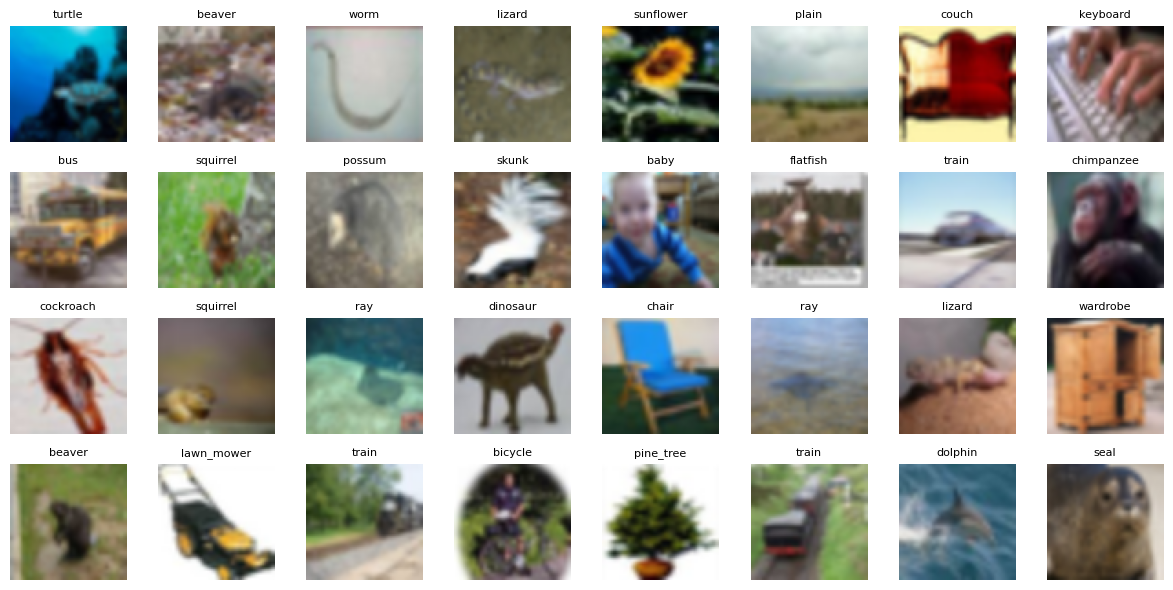

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize the image
def denormalize(image):
    image = image * 0.5 + 0.5  # Scale to [0, 1]
    return image

# CIFAR-100 class names
class_names = train_dataset.dataset.classes

# Get a batch of images and labels from the training DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert the images from tensors to NumPy arrays
images = images.numpy()

# Denormalize the images
images = denormalize(images)

# Plot the images with their labels
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Transpose the image from (C, H, W) to (H, W, C) for Matplotlib
        img = np.transpose(images[i], (1, 2, 0))
        ax.imshow(img)
        ax.set_title(class_names[labels[i]], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


## training loop

In [ ]:
import timeit
from tqdm.notebook import tqdm

# init model
model = ViT(n_encoders, latent_size, n_classes, dropout).to(device)
# COST
criterion = nn.CrossEntropyLoss()

# Optimizer
opt = optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)

train_lossL = []
val_lossL = []
accuracy = []
start = start = timeit.default_timer()
# epoch loop
for epoch in tqdm(range(epochs), desc='Epochs'):
    model.train()
    train_loss = 0.0
    correct = 0
    total_samples = 0
    val_loss = 0.0

    # train loop
    for batch, (image, label) in tqdm(enumerate(train_loader), desc=f'Training Epoch {epoch}', leave=False):

        image, label = image.to(device), label.to(device)
        # print(image.shape)  # Should be (batch_size, channels, height, width)
        opt.zero_grad() # Zero out gradient
        preds = model(image)
        loss = criterion(preds, label) # calc loss
        loss.backward() # backprop
        opt.step() # step
        train_loss += loss.item()

    # store loss
    Epoch_loss = train_loss / len(train_loader)
    train_lossL.append(Epoch_loss)

    # val loop
    model.eval()
    with torch.no_grad():
        for batch, (image, label) in enumerate(val_loader):
            image, label = image.to(device), label.to(device)
            preds = model(image)
            loss = criterion(preds, label)
            val_loss += loss.item()

            # get labels argmax for accurqcy
            y_pred_label = torch.argmax(preds, dim=1)
            correct += (y_pred_label == label).sum().item()
            total_samples += label.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    val_lossL.append(epoch_val_loss)
    epoch_accuracy = correct / total_samples
    accuracy.append(epoch_accuracy)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {epoch_accuracy:.4f}")

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Training Epoch 0: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 1: 2907.2143
Valid Loss EPOCH 1: 746.9903
Valid Accuracy EPOCH 1: 0.0103


Training Epoch 1: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 2: 2879.4745
Valid Loss EPOCH 2: 746.1938
Valid Accuracy EPOCH 2: 0.0090


Training Epoch 2: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 3: 2878.4416
Valid Loss EPOCH 3: 746.1089
Valid Accuracy EPOCH 3: 0.0079


Training Epoch 3: 0it [00:00, ?it/s]

Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x79e4e802b600>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e4e802b600>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

------------------------------
Train Loss EPOCH 4: 2878.4008
Valid Loss EPOCH 4: 746.1149
Valid Accuracy EPOCH 4: 0.0084


Training Epoch 4: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 5: 2878.4036
Valid Loss EPOCH 5: 746.1274
Valid Accuracy EPOCH 5: 0.0090


Training Epoch 5: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 6: 2878.4179
Valid Loss EPOCH 6: 746.1157
Valid Accuracy EPOCH 6: 0.0096


Training Epoch 6: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 7: 2878.3938
Valid Loss EPOCH 7: 746.1257
Valid Accuracy EPOCH 7: 0.0086


Training Epoch 7: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 8: 2878.4122
Valid Loss EPOCH 8: 746.1205
Valid Accuracy EPOCH 8: 0.0093


Training Epoch 8: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 9: 2878.3893
Valid Loss EPOCH 9: 746.1030
Valid Accuracy EPOCH 9: 0.0090


Training Epoch 9: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 10: 2878.4266
Valid Loss EPOCH 10: 746.1271
Valid Accuracy EPOCH 10: 0.0079


Training Epoch 10: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 11: 2878.4097
Valid Loss EPOCH 11: 746.1330
Valid Accuracy EPOCH 11: 0.0084


Training Epoch 11: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 12: 2878.4134
Valid Loss EPOCH 12: 746.1319
Valid Accuracy EPOCH 12: 0.0086


Training Epoch 12: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 13: 2878.4103
Valid Loss EPOCH 13: 746.1190
Valid Accuracy EPOCH 13: 0.0079


Training Epoch 13: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 14: 2878.4187
Valid Loss EPOCH 14: 746.1053
Valid Accuracy EPOCH 14: 0.0079


Training Epoch 14: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 15: 2878.3992
Valid Loss EPOCH 15: 746.1189
Valid Accuracy EPOCH 15: 0.0083


Training Epoch 15: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 16: 2878.4140
Valid Loss EPOCH 16: 746.1361
Valid Accuracy EPOCH 16: 0.0087


Training Epoch 16: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 17: 2878.4101
Valid Loss EPOCH 17: 746.1355
Valid Accuracy EPOCH 17: 0.0079


Training Epoch 17: 0it [00:00, ?it/s]

------------------------------
Train Loss EPOCH 18: 2878.3846
Valid Loss EPOCH 18: 746.1206
Valid Accuracy EPOCH 18: 0.0090


Training Epoch 18: 0it [00:00, ?it/s]

In [6]:
labels = []
# ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        # ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

plt.imshow()

NameError: name 'model' is not defined

In [ ]:
# save the model
torch.save(model.state_dict(), 'Vit_model.pth')

# load the model
model.load_state_dict(torch.load('Vit_model.pth'))

# infer and plot samples with saved model
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
